# 12: Feature Importance Analysis

This notebook focuses on extracting, visualizing, and comparing feature importances from the trained models, performing SHAP value analysis, and conducting statistical feature significance tests for deeper insights.

**PRD References:** 3.1.6 (Feature Importance), FR4 (Identify Key Predictors), 9.1 (Jupyter Notebooks), 8 (Interpretability - SHAP).

## 1. Setup and Imports

In [7]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import shap 

# Feature selection utilities
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Ensure src directory is in Python path
sys.path.append(str(Path.cwd().parent / 'src'))

# Custom utilities
from modeling_utils import load_model 
from sklearn.model_selection import train_test_split 

# Configuration
DATA_DIR = Path.cwd().parent / 'data'
PROCESSED_DATA_FILE = DATA_DIR / 'processed' / 'preprocessed_data.csv'
MODELS_DIR = Path.cwd().parent / 'models'
REPORTS_DIR = Path.cwd().parent / 'reports'
FIGURES_DIR = REPORTS_DIR / 'figures' / 'feature_importance'
SHAP_FIGURES_DIR = REPORTS_DIR / 'figures' / 'shap_analysis'
STAT_TESTS_FIGURES_DIR = REPORTS_DIR / 'figures' / 'stat_tests_importance'
RANDOM_STATE = 42

MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
SHAP_FIGURES_DIR.mkdir(parents=True, exist_ok=True)
STAT_TESTS_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

sns.set_style('whitegrid')
shap.initjs() 

## 2. Load Data and Prepare for Analysis

Load preprocessed data to get feature names and prepare X_train/X_test for SHAP analysis and statistical tests.

In [8]:
X_data, y_data = None, None # Renamed from X_shap, y_shap for general use
X_train_data, X_test_data, y_train_data, y_test_data = None, None, None, None
feature_names = None

try:
    df = pd.read_csv(PROCESSED_DATA_FILE)
    if 'SEVERITY' in df.columns:
        y_data = df['SEVERITY']
        X_data = df.drop('SEVERITY', axis=1)
        feature_names = X_data.columns.tolist()
        print(f"Successfully loaded {len(feature_names)} feature names.")
        
        # Split data (consistent with modeling notebooks)
        X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(
            X_data, y_data, test_size=0.2, random_state=RANDOM_STATE, stratify=y_data
        )
        print(f"X_train_data shape: {X_train_data.shape}, X_test_data shape: {X_test_data.shape}")
    else:
        print("Error: Target column 'SEVERITY' not found in the preprocessed data.")
except FileNotFoundError:
    print(f"Error: Processed data file not found at {PROCESSED_DATA_FILE}")
    print("Please ensure '02_data_preprocessing.ipynb' has been run successfully.")
except Exception as e:
    print(f"An error occurred while loading data: {e}")

if feature_names:
    print(f"First 5 features: {feature_names[:5]}")

Successfully loaded 43 feature names.
X_train_data shape: (17657, 43), X_test_data shape: (4415, 43)
First 5 features: ['Y', 'X', 'hour', 'day_of_week', 'day']


## 3. Load Trained Models

We will load the best versions of Logistic Regression and various tree-based models.

In [9]:
models_to_load = {
    'Logistic Regression': 'logistic_regression_best_model.pkl',
    'Decision Tree': 'decision_tree_model.joblib', 
    'Random Forest': 'random_forest_best_model.joblib',
    'LightGBM': 'lightgbm_best_model.joblib',
    'XGBoost': 'xgboost_best_model.joblib',
    'Bagging Classifier': 'baggingclassifier_best_model.joblib',
    'AdaBoost': 'adaboost_best_model.joblib'
}

loaded_models = {}
if feature_names: 
    for model_name, model_filename in models_to_load.items():
        model_path = MODELS_DIR / model_filename
        print(f"\nLoading {model_name} from {model_path}...")
        model = load_model(model_path, model_name=model_name)
        if model:
            loaded_models[model_name] = model
        else:
            print(f"Could not load {model_name}. It will be skipped in the analysis.")
else:
    print("Feature names not loaded. Skipping model loading.")

print(f"\nSuccessfully loaded models: {list(loaded_models.keys())}")


Loading Logistic Regression from /home/cmark/Projects/TrafficAccidentSeverity/models/logistic_regression_best_model.pkl...
Logistic Regression loaded successfully from /home/cmark/Projects/TrafficAccidentSeverity/models/logistic_regression_best_model.pkl

Loading Decision Tree from /home/cmark/Projects/TrafficAccidentSeverity/models/decision_tree_model.joblib...
Decision Tree loaded successfully from /home/cmark/Projects/TrafficAccidentSeverity/models/decision_tree_model.joblib

Loading Random Forest from /home/cmark/Projects/TrafficAccidentSeverity/models/random_forest_best_model.joblib...
Random Forest loaded successfully from /home/cmark/Projects/TrafficAccidentSeverity/models/random_forest_best_model.joblib

Loading LightGBM from /home/cmark/Projects/TrafficAccidentSeverity/models/lightgbm_best_model.joblib...
LightGBM loaded successfully from /home/cmark/Projects/TrafficAccidentSeverity/models/lightgbm_best_model.joblib

Loading XGBoost from /home/cmark/Projects/TrafficAccidentSe

## 4. Extract and Visualize Model-Based Feature Importances

For tree-based models, we use `feature_importances_`. For Logistic Regression, we use `coef_[0]`.

Mismatch in number of importances (42) and feature names (43) for Logistic Regression.
Mismatch in number of importances (39) and feature names (43) for Decision Tree.

Top 5 features for Random Forest:
            feature  importance
0                 Y    0.148123
1                 X    0.143706
2              hour    0.124488
4               day    0.116085
41  desc_word_count    0.083329


/tmp/ipykernel_583083/880849150.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=plot_data, palette='viridis')


Saved plot to /home/cmark/Projects/TrafficAccidentSeverity/reports/figures/feature_importance/random_forest_feature_importance.png


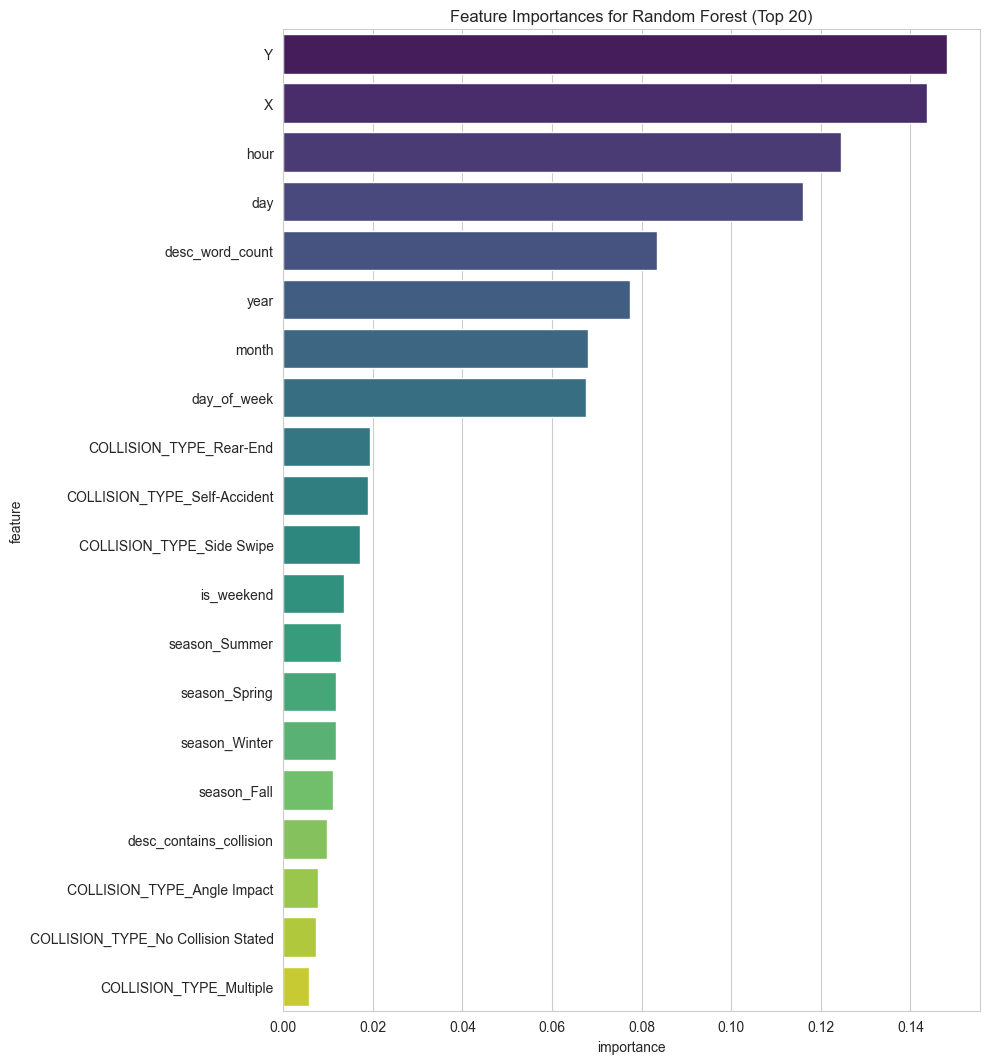


Top 5 features for LightGBM:
            feature  importance
1                 X         255
0                 Y         247
2              hour         148
41  desc_word_count         145
6              year         116


/tmp/ipykernel_583083/880849150.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=plot_data, palette='viridis')


Saved plot to /home/cmark/Projects/TrafficAccidentSeverity/reports/figures/feature_importance/lightgbm_feature_importance.png


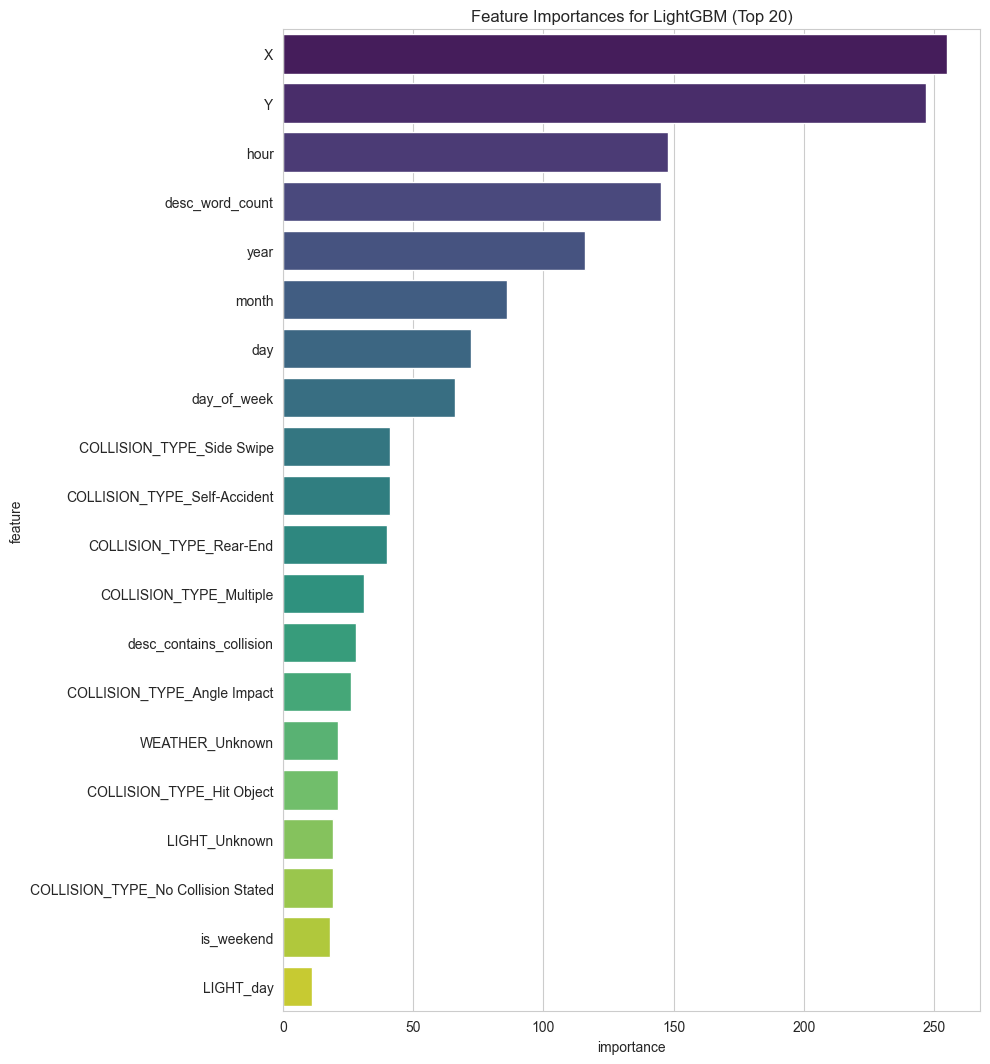


Top 5 features for XGBoost:
                         feature  importance
20  COLLISION_TYPE_Self-Accident    0.099566
22               WEATHER_Unknown    0.081516
30                 LIGHT_Unknown    0.064340
17       COLLISION_TYPE_Multiple    0.047265
31                     LIGHT_day    0.046173


/tmp/ipykernel_583083/880849150.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=plot_data, palette='viridis')


Saved plot to /home/cmark/Projects/TrafficAccidentSeverity/reports/figures/feature_importance/xgboost_feature_importance.png


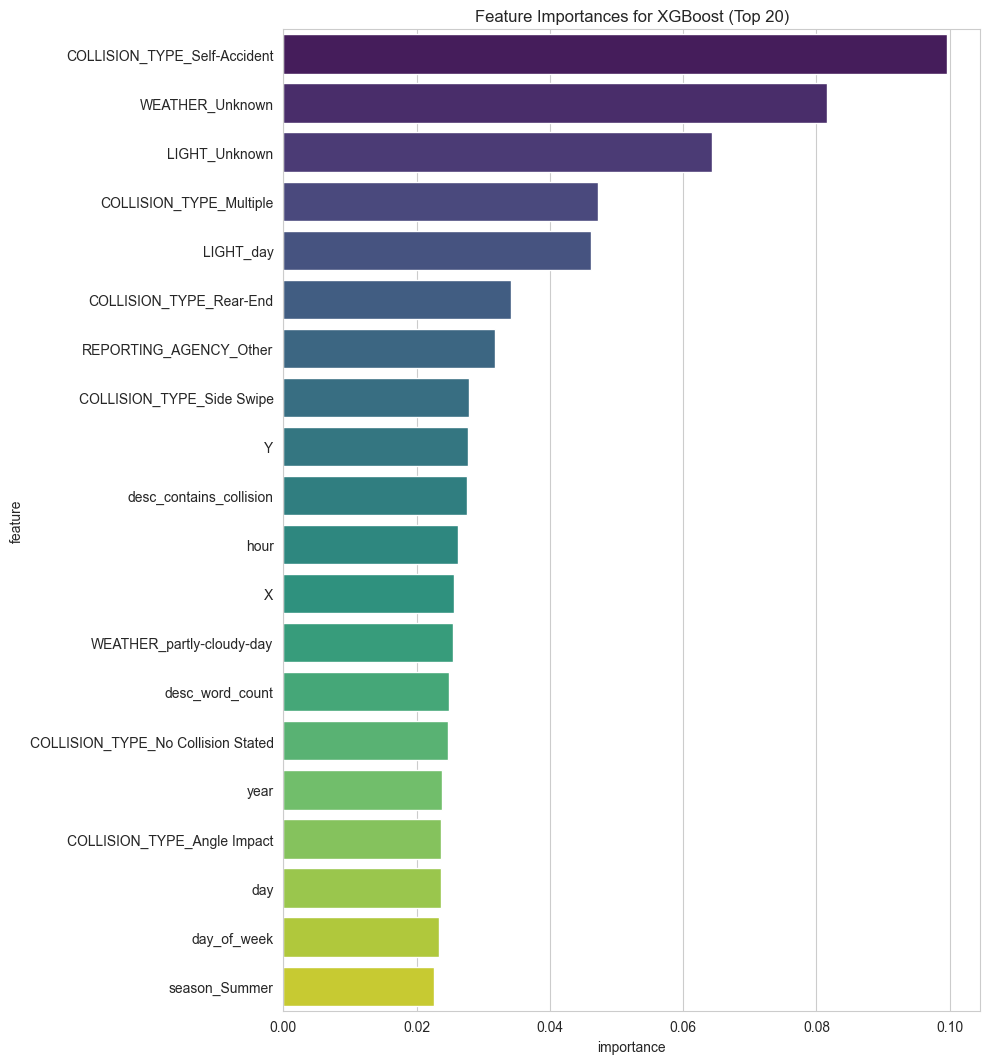

Could not extract feature importances for Bagging Classifier. Skipping.

Top 5 features for AdaBoost:
                         feature  importance
20  COLLISION_TYPE_Self-Accident    0.266660
41               desc_word_count    0.230973
2                           hour    0.124840
19       COLLISION_TYPE_Rear-End    0.076861
1                              X    0.076725


/tmp/ipykernel_583083/880849150.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=plot_data, palette='viridis')


Saved plot to /home/cmark/Projects/TrafficAccidentSeverity/reports/figures/feature_importance/adaboost_feature_importance.png


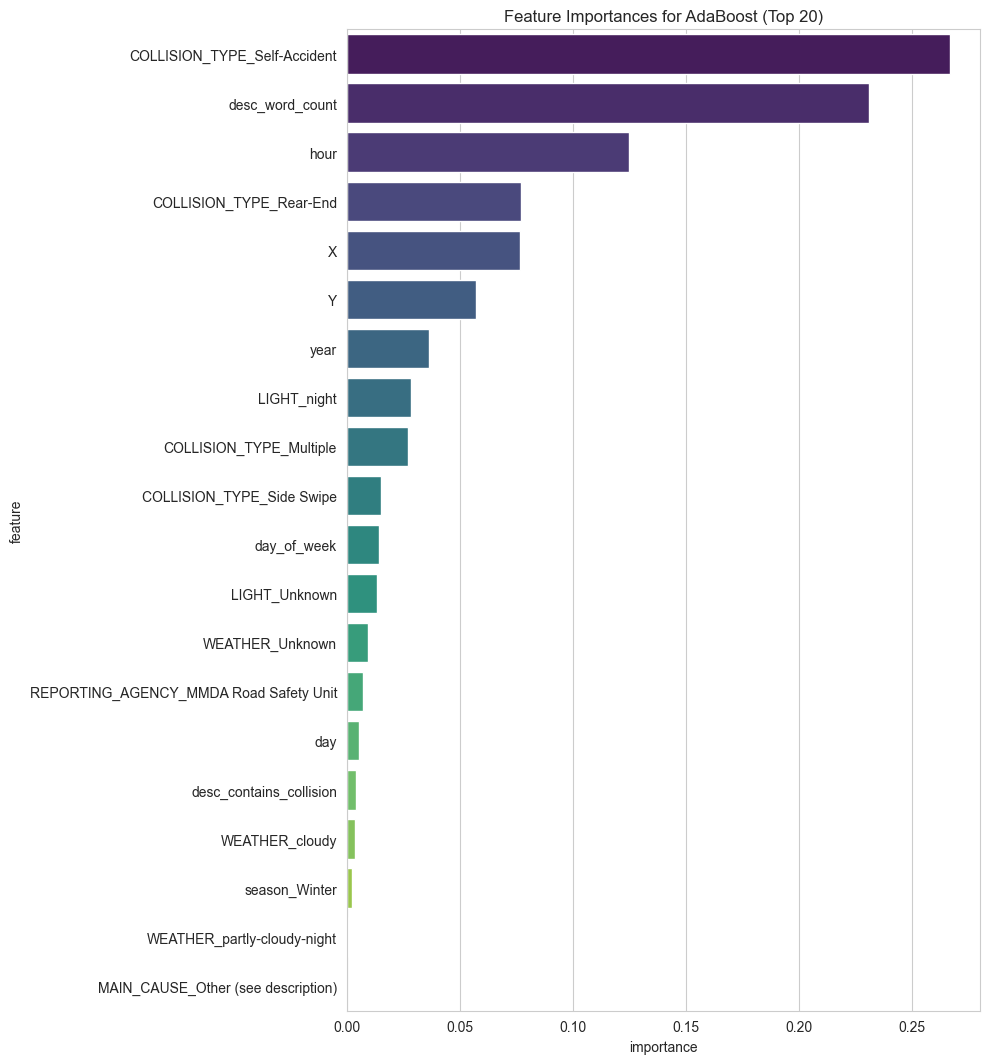

In [10]:
all_feature_importances = {}

if feature_names and loaded_models:
    for model_name, model in loaded_models.items():
        try:
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            elif hasattr(model, 'coef_') and model_name == 'Logistic Regression':
                importances = model.coef_[0] 
            else:
                print(f"Could not extract feature importances for {model_name}. Skipping.")
                continue
            
            if len(importances) == len(feature_names):
                importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
                if model_name == 'Logistic Regression':
                    importance_df['abs_importance'] = importance_df['importance'].abs()
                    importance_df = importance_df.sort_values(by='abs_importance', ascending=False)
                else:
                    importance_df = importance_df.sort_values(by='importance', ascending=False)
                all_feature_importances[model_name] = importance_df
                print(f"\nTop 5 features for {model_name}:")
                print(importance_df.head())

                plt.figure(figsize=(10, max(6, len(feature_names) * 0.25)))
                num_features_to_plot = min(20, len(importance_df))
                plot_data = importance_df.head(num_features_to_plot)
                sns.barplot(x='importance', y='feature', data=plot_data, palette='viridis')
                plt.title(f'Feature Importances for {model_name} (Top {num_features_to_plot})')
                plt.tight_layout()
                plot_filename = FIGURES_DIR / f'{model_name.lower().replace(" ", "_")}_feature_importance.png'
                plt.savefig(plot_filename)
                print(f"Saved plot to {plot_filename}")
                plt.show()
            else:
                print(f"Mismatch in number of importances ({len(importances)}) and feature names ({len(feature_names)}) for {model_name}.")
        except Exception as e:
            print(f"Error processing feature importances for {model_name}: {e}")
else:
    print("Feature names or models not loaded. Skipping feature importance extraction.")

## 5. Comparative Analysis of Model-Based Importances


Comparative Top Features Summary (Model-Based Importances):
            model                             feature  importance  rank
0   Random Forest                                   X    0.117763     1
1   Random Forest                                   Y    0.111438     2
2   Random Forest                                hour    0.105749     3
3   Random Forest                     desc_word_count    0.097879     4
4   Random Forest                                 day    0.077942     5
5   Random Forest        COLLISION_TYPE_Self-Accident    0.073643     6
6   Random Forest                         day_of_week    0.052407     7
7   Random Forest                                year    0.046978     8
8   Random Forest                               month    0.045357     9
9   Random Forest             COLLISION_TYPE_Rear-End    0.043796    10
10        XGBoost        COLLISION_TYPE_Self-Accident    0.135885     1
11        XGBoost             desc_contains_collision    0.106182     2
12 

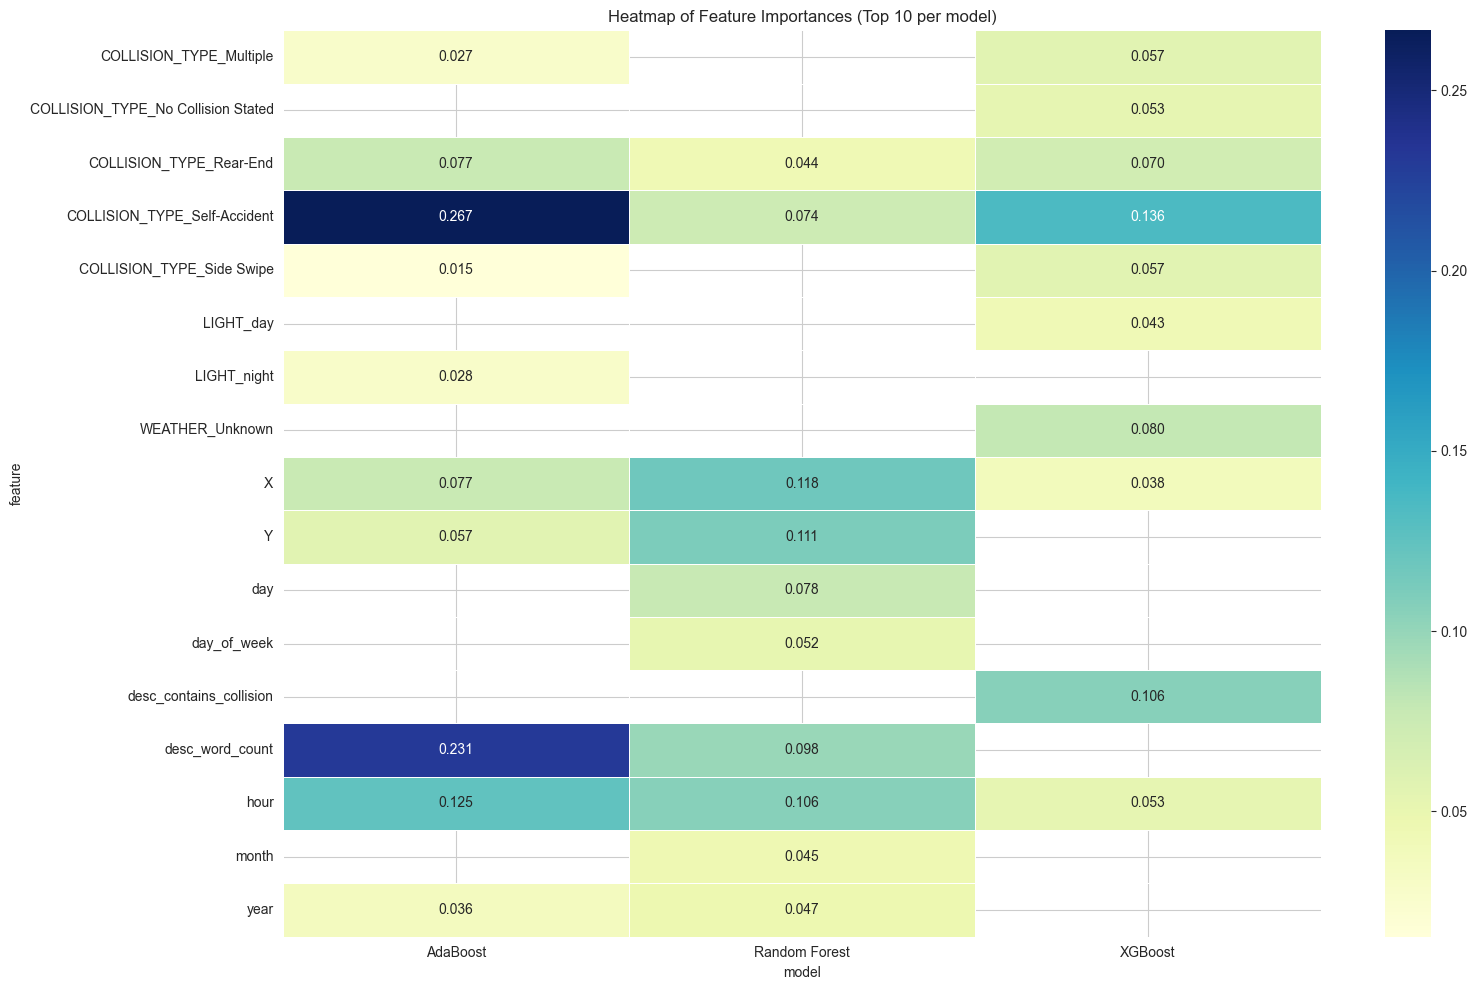

In [10]:
N_TOP_FEATURES = 10
comparative_importances_list = [] 

if all_feature_importances:
    for model_name, importance_df in all_feature_importances.items():
        df_to_compare = importance_df.copy()
        sort_col = 'abs_importance' if 'abs_importance' in df_to_compare.columns else 'importance'
        df_to_compare = df_to_compare.sort_values(by=sort_col, ascending=False)
        
        top_n = df_to_compare.head(N_TOP_FEATURES)
        rank = 1
        for idx, row in top_n.iterrows():
            comparative_importances_list.append({
                'model': model_name,
                'feature': row['feature'],
                'importance': row['importance'], 
                'rank': rank
            })
            rank += 1

    if comparative_importances_list:
        comparative_df = pd.DataFrame(comparative_importances_list)
        print("\nComparative Top Features Summary (Model-Based Importances):")
        print(comparative_df)
        
        try:
            pivot_df = comparative_df.pivot_table(index='feature', columns='model', values='importance')
            plt.figure(figsize=(16, max(10, len(pivot_df) * 0.35)))
            sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".3f", linewidths=.5)
            plt.title(f'Heatmap of Feature Importances (Top {N_TOP_FEATURES} per model)')
            plt.tight_layout()
            heatmap_filename = FIGURES_DIR / 'comparative_model_based_importance_heatmap.png'
            plt.savefig(heatmap_filename)
            print(f"Saved heatmap to {heatmap_filename}")
            plt.show()
        except Exception as e:
            print(f"Could not generate heatmap for model-based importances: {e}")
else:
    print("No model-based feature importances were extracted, skipping comparative analysis.")

## 6. SHAP Value Analysis

SHAP (SHapley Additive exPlanations) values provide a more nuanced view of feature importance, showing not just the magnitude but also the direction of impact for each feature on individual predictions. We'll analyze one or two of our top-performing tree-based models.

In [11]:
models_for_shap = ['XGBoost', 'LightGBM'] 
shap_values_dict = {}
explainers_dict = {}

if X_test_data is not None and feature_names: # Changed from X_test_shap
    shap_background_data = shap.sample(X_train_data, 100) if len(X_train_data) > 100 else X_train_data
    shap_eval_data = shap.sample(X_test_data, 200) if len(X_test_data) > 200 else X_test_data
    print(f"Using background data of shape {shap_background_data.shape} and eval data of shape {shap_eval_data.shape} for SHAP.")

    for model_key in models_for_shap:
        if model_key in loaded_models:
            model_to_explain = loaded_models[model_key]
            print(f"\n--- Generating SHAP values for {model_key} ---")
            try:
                if model_key in ['XGBoost', 'LightGBM', 'Random Forest', 'Decision Tree', 'Bagging Classifier', 'AdaBoost']:
                    explainer = shap.TreeExplainer(model_to_explain, data=shap_background_data) 
                else: 
                    print(f"Using KernelExplainer for {model_key}. This might be slow.")
                    explainer = shap.KernelExplainer(model_to_explain.predict_proba, shap_background_data)
                
                explainers_dict[model_key] = explainer
                shap_values_raw = explainer.shap_values(shap_eval_data)
                
                if isinstance(shap_values_raw, list) and len(shap_values_raw) == 2:
                    shap_values_for_positive_class = shap_values_raw[1] 
                else:
                    shap_values_for_positive_class = shap_values_raw 
                
                shap_values_dict[model_key] = shap_values_for_positive_class
                print(f"SHAP values calculated for {model_key}.")

                plt.figure()
                shap.summary_plot(shap_values_for_positive_class, shap_eval_data, feature_names=feature_names, show=False)
                plt.title(f'SHAP Summary Plot for {model_key}')
                plt.tight_layout()
                shap_summary_filename = SHAP_FIGURES_DIR / f'{model_key.lower().replace(" ", "_")}_shap_summary.png'
                plt.savefig(shap_summary_filename, bbox_inches='tight')
                print(f"Saved SHAP summary plot to {shap_summary_filename}")
                plt.show()

                mean_abs_shap = np.abs(shap_values_for_positive_class).mean(0)
                top_shap_indices = np.argsort(mean_abs_shap)[::-1][:3] 

                for feature_idx in top_shap_indices:
                    feature_to_plot = feature_names[feature_idx]
                    plt.figure()
                    shap.dependence_plot(feature_to_plot, shap_values_for_positive_class, shap_eval_data, feature_names=feature_names, interaction_index='auto', show=False)
                    plt.title(f'SHAP Dependence Plot for {feature_to_plot} ({model_key})')
                    plt.tight_layout()
                    shap_dependence_filename = SHAP_FIGURES_DIR / f'{model_key.lower().replace(" ", "_")}_shap_dependence_{feature_to_plot.replace("/", "_")}.png'
                    plt.savefig(shap_dependence_filename, bbox_inches='tight')
                    print(f"Saved SHAP dependence plot for {feature_to_plot} to {shap_dependence_filename}")
                    plt.show()
            except Exception as e:
                print(f"Error during SHAP analysis for {model_key}: {e}")
        else:
            print(f"Model {model_key} not loaded, skipping SHAP analysis.")
else:
    print("X_test_data or feature_names not available. Skipping SHAP analysis.")

Using background data of shape (100, 43) and eval data of shape (200, 43) for SHAP.

--- Generating SHAP values for XGBoost ---
Error during SHAP analysis for XGBoost: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

--- Generating SHAP values for LightGBM ---
Error during SHAP analysis for LightGBM: 'TreeEnsemble' object has no attribute 'values'


Found a NULL input array in _cext_dense_tree_update_weights!
Found a NULL input array in _cext_dense_tree_update_weights!


## 7. Statistical Feature Significance Tests (Chi-squared and ANOVA F-test)

These tests provide a statistical assessment of the relationship between individual features and the target variable. 
- **Chi-squared (χ²)**: Used for categorical features against a categorical target. Tests for independence.
- **ANOVA F-test**: Used for numerical features against a categorical target. Tests if group means (defined by target classes) are significantly different.


--- Performing Statistical Feature Significance Tests ---

Top features by Chi-squared score:
                            feature  chi2_score   chi2_pvalue
20     COLLISION_TYPE_Self-Accident  311.614837  9.715078e-70
2                              hour  305.612273  1.972800e-68
33                      LIGHT_night   64.817902  8.214941e-16
28      WEATHER_partly-cloudy-night   63.380240  1.704190e-15
34  REPORTING_AGENCY_MMDA Metrobase   62.559272  2.585453e-15


/tmp/ipykernel_483322/545091476.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='chi2_score', y='feature', data=chi2_scores.head(num_chi2_to_plot), palette='coolwarm')


Saved Chi-squared scores plot to /home/cmark/Projects/TrafficAccidentSeverity/reports/figures/stat_tests_importance/chi2_scores.png


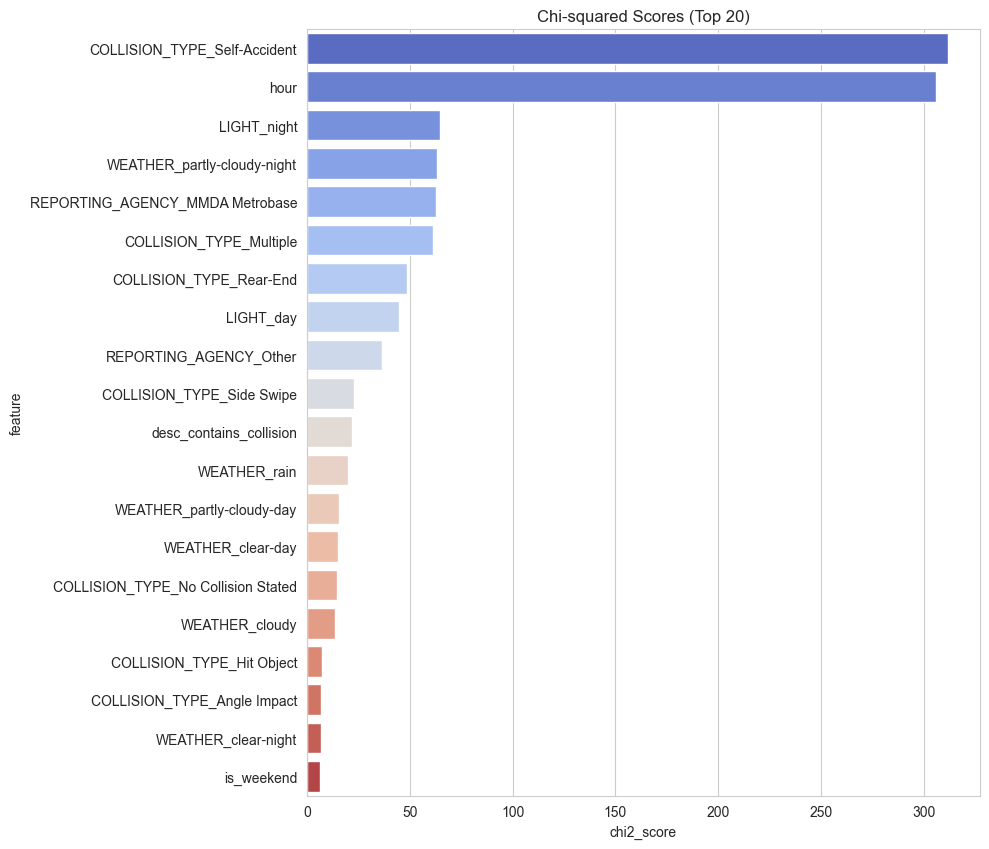

/home/cmark/Projects/TrafficAccidentSeverity/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 8 26] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/cmark/Projects/TrafficAccidentSeverity/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/tmp/ipykernel_483322/545091476.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='f_score', y='feature', data=f_scores.head(num_f_to_plot), palette='coolwarm')



Top features by ANOVA F-score:
                                   feature     f_score      f_pvalue
20            COLLISION_TYPE_Self-Accident  320.428477  4.958529e-71
30                           LIGHT_Unknown  100.535930  1.344661e-23
35  REPORTING_AGENCY_MMDA Road Safety Unit  100.535930  1.344661e-23
22                         WEATHER_Unknown  100.535930  1.344661e-23
33                             LIGHT_night   65.275693  6.928623e-16
Saved ANOVA F-scores plot to /home/cmark/Projects/TrafficAccidentSeverity/reports/figures/stat_tests_importance/anova_f_scores.png


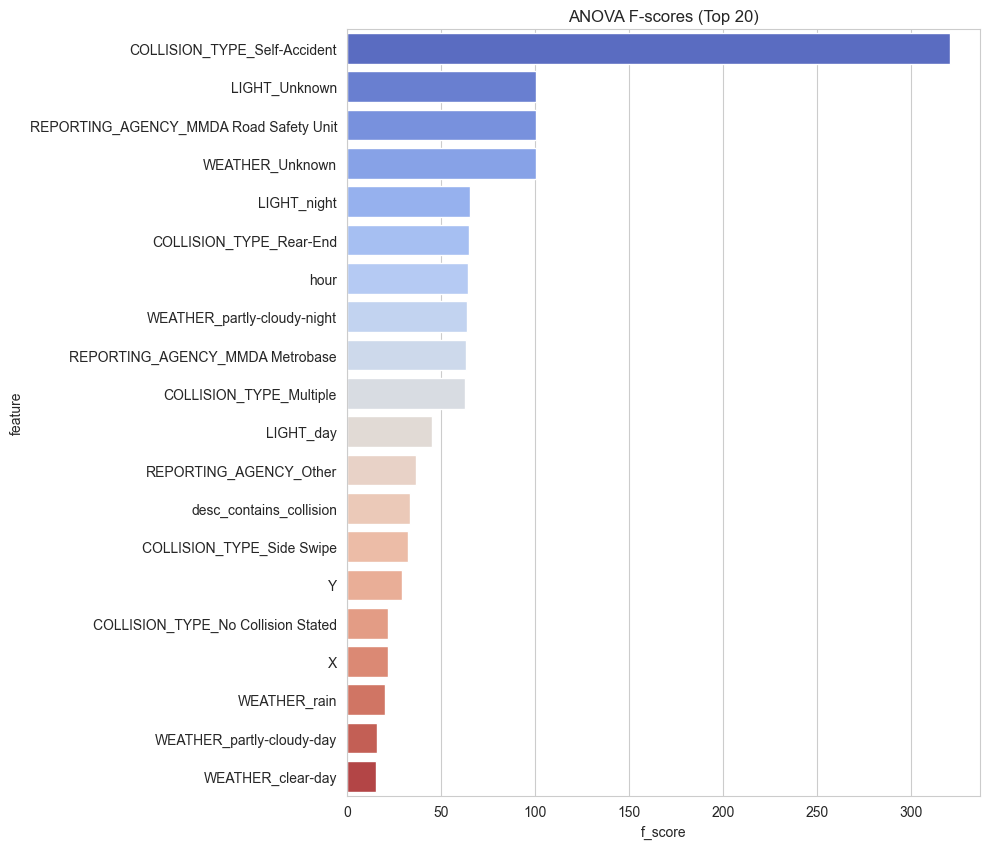

In [12]:
if X_train_data is not None and y_train_data is not None and feature_names:
    print("\n--- Performing Statistical Feature Significance Tests ---")
    
    # Chi-squared Test (for non-negative features, typically categorical or OHE)
    # Ensure all data for chi2 is non-negative. OHE features are 0 or 1, which is fine.
    # If other features are present and could be negative, they should be excluded or transformed.
    # For simplicity, we apply it to all features assuming they are appropriately encoded (e.g. OHE, scaled non-negative).
    # If X_train_data contains negative values from scaling, chi2 will raise an error.
    # We should ideally select only OHE columns or non-negative discrete features for chi2.
    # However, our preprocessed_data.csv does not involve scaling yet, so OHE features are 0/1.
    # 'Y' and 'X' (coordinates) are numerical and might be negative if not properly handled before this stage.
    # Let's assume X_train_data is suitable or filter appropriately.

    # For Chi2, we need to ensure no negative values. Let's check and filter if necessary.
    if (X_train_data < 0).any().any():
        print("Warning: Chi-squared test requires non-negative features. Some features might be excluded or results affected if negative values exist from scaling.")
        # A simple strategy: apply only to columns where all values are non-negative
        non_negative_cols = X_train_data.columns[(X_train_data >= 0).all()]
        X_chi2_data = X_train_data[non_negative_cols]
        chi2_feature_names = non_negative_cols.tolist()
    else:
        X_chi2_data = X_train_data
        chi2_feature_names = feature_names

    if not X_chi2_data.empty:
        try:
            chi2_selector = SelectKBest(score_func=chi2, k='all')
            chi2_selector.fit(X_chi2_data, y_train_data)
            chi2_scores = pd.DataFrame({'feature': chi2_feature_names, 'chi2_score': chi2_selector.scores_, 'chi2_pvalue': chi2_selector.pvalues_})
            chi2_scores = chi2_scores.sort_values(by='chi2_score', ascending=False)
            print("\nTop features by Chi-squared score:")
            print(chi2_scores.head())

            plt.figure(figsize=(10, max(6, len(chi2_feature_names) * 0.2)))
            num_chi2_to_plot = min(20, len(chi2_scores))
            sns.barplot(x='chi2_score', y='feature', data=chi2_scores.head(num_chi2_to_plot), palette='coolwarm')
            plt.title(f'Chi-squared Scores (Top {num_chi2_to_plot})')
            plt.tight_layout()
            chi2_plot_filename = STAT_TESTS_FIGURES_DIR / 'chi2_scores.png'
            plt.savefig(chi2_plot_filename)
            print(f"Saved Chi-squared scores plot to {chi2_plot_filename}")
            plt.show()
        except ValueError as ve:
            print(f"Error during Chi-squared test (likely due to negative input values): {ve}")
        except Exception as e:
            print(f"An unexpected error occurred during Chi-squared test: {e}")
    else:
        print("Skipping Chi-squared test as no suitable non-negative features were found.")

    # ANOVA F-test (for numerical features vs. categorical target)
    # We can apply this to all features, as it's robust to OHE features as well.
    try:
        f_selector = SelectKBest(score_func=f_classif, k='all')
        f_selector.fit(X_train_data, y_train_data)
        f_scores = pd.DataFrame({'feature': feature_names, 'f_score': f_selector.scores_, 'f_pvalue': f_selector.pvalues_})
        f_scores = f_scores.sort_values(by='f_score', ascending=False)
        print("\nTop features by ANOVA F-score:")
        print(f_scores.head())

        plt.figure(figsize=(10, max(6, len(feature_names) * 0.2)))
        num_f_to_plot = min(20, len(f_scores))
        sns.barplot(x='f_score', y='feature', data=f_scores.head(num_f_to_plot), palette='coolwarm')
        plt.title(f'ANOVA F-scores (Top {num_f_to_plot})')
        plt.tight_layout()
        f_plot_filename = STAT_TESTS_FIGURES_DIR / 'anova_f_scores.png'
        plt.savefig(f_plot_filename)
        print(f"Saved ANOVA F-scores plot to {f_plot_filename}")
        plt.show()
    except Exception as e:
        print(f"An error occurred during ANOVA F-test: {e}")
else:
    print("Data for statistical tests not available. Skipping.")

## 8. Conclusion

This notebook loaded the trained models, extracted their respective feature importances (or coefficients for Logistic Regression), and visualized them. A preliminary comparative analysis of model-based importances was performed. Furthermore, SHAP value analysis was conducted for selected models to provide deeper insights into feature contributions and interactions. Finally, statistical tests (Chi-squared and ANOVA F-test) were applied to assess feature significance from a different perspective. These combined insights help in understanding which features are most influential for each model in predicting severe traffic accidents.